In this notebook, we will run a ready-made network starting from some ATLAS data, which is already normalized. There is also an alternative to train the network from scratch.  

## Look into the dataset

First we need to make sure that Python 3.8 is used in the notebook. It is required in order to open this certain .pkl-file. 

In [1]:
import random
import sys
sys.version

'3.8.6 (default, Sep 25 2020, 09:36:53) \n[GCC 10.2.0]'

We take a pickle dataset, and open into Pandas (after importing pandas). Note that you have to change the paths to the directory where your processed files are. 

In [2]:
import pandas as pd

# Change these paths to point to where you have stored the datasets. 
# train_path = '/Users/nallenallis/Documents/LTH/Exjobb/data/TLA_leadingJet_custom_normalized_train_80.pkl'
# test_path = '/Users/nallenallis/Documents/LTH/Exjobb/data/TLA_leadingJet_custom_normalized_train_20.pkl'

# Reads the .pkl-files with Pandas
# train = pd.read_pickle(train_path)
# test = pd.read_pickle(test_path)

# Read accordingly
main_df = pd.read_csv('./sample_data.csv', delimiter=';')
# Parse only after event Id, process ID, MET and go directly into four-momentum jet particles
df_parsed = main_df.iloc[:,5:]
# parse only j-jet particles
df_only_js = df_parsed.applymap(lambda x: x if 'j' in str(x) else None)

def raise_(ex):
    raise ex
# Throw error for values with incompatible eta (pseudorapidity abs(eta)>=2.8), as Delphes would have done this already
#df_parsed.applymap(lambda x: raise_(ValueError(f'Incorrect value for eta: {float(str(x).split(",")[3])}')) if abs(float(str(x).split(',')[3]))>=2.8 else x)
# Throw error for incorrect transverse momentum p_t <= 20 Giga electron volt  as Delphes would have done this already
#df_parsed.applymap(lambda x: raise_(ValueError(f'Incorrect value for Pt (transv. momentum): {float(str(x).split(",")[2])}')) if abs(float(str(x).split(',')[2]))<=20 else x)

# Flip dataset into one column respectively 'Value'
melted_js = df_parsed.melt(id_vars=[],
        var_name="Object Type", value_name="Value")

# Split dataset
split_df = pd.DataFrame()
split_df[['obj', 'E', 'pt', 'eta', 'phi']] = melted_js['Value'].str.split(pat=",", expand=True)

# we could also check for total sum E_t and H_t<600 but it is trivial from the dataset these conditions are met
# Filter out 'None' cells (invalid ones)
notnull_df = split_df.loc[split_df['obj'].notnull()]
# Reset indexes
notnull_df = notnull_df.reset_index(drop=True)
# Take 'Object' out as 'j' is normally in all sets
clean_df = notnull_df.iloc[:,1:]
# Convert values to float
clean_df = clean_df.applymap(lambda x: float(x) if x else x)

# Throw error for values with incompatible eta (pseudorapidity abs(eta)>=2.8), as Delphes would have done this already
# if len(clean_df.loc[abs(clean_df['eta']) >= 2.8]) > 0:
#    raise ValueError(f'Incorrect values for eta found !!! (|eta|>=2.8)')
# I may have interpreted data incorrectly as some etas appear ot go out of range from Delphas >=2.8 conditions as presented in paper



# Throw error for incorrect transverse momentum p_t <= 20 Giga electron volt  as Delphes would have done this already
if len(clean_df.loc[clean_df['pt'] <= 20]) > 0:
   raise ValueError(f'Incorrect values for phi found !!! (pt <= 20 GeV)')

# Now we shall split the data in 2 sets, training, testing we can randomly allocate lines accordingly with 80/20 method
df_ll = len(clean_df)
# Pre-Allocate random test/train row seq randomly at 80/20 typical split method
r = list(range(df_ll))
random.shuffle(r)
radius = int(df_ll * 0.8)
train_r = r[:radius]
test_r = r[radius+1:]

train = clean_df[clean_df.index.isin(train_r)]
test = clean_df[clean_df.index.isin(test_r)]


# To get an idea of the order of magnitude we are going to see in the plots we show the first elements
# in the samples:
print('Training sample:')
print(train.head())

print('\n')

print('Testing sample:')
print(test.head())

print('\n')

print('The number of entries in the training data:', len(train))
print('The number of entries in the validation data:', len(test))

Training sample:
           E        pt       eta       phi
1  1069460.0  751597.0  0.858186 -1.842170
2   676000.0  640429.0  0.330450  0.704554
5   583373.0  545730.0  0.364057 -1.607320
6   413325.0  262272.0  1.026580 -2.695650
7   725985.0  520934.0  0.844130  0.958992


Testing sample:
           E        pt       eta       phi
0   947383.0  824498.0 -0.523103  1.644210
3   936707.0  616229.0  0.973383 -1.565920
4   640313.0  589524.0  0.390749  1.237340
13  522824.0  411351.0 -0.716307  0.954073
23  815050.0  678926.0 -0.612176 -0.340187


The number of entries in the training data: 18778
The number of entries in the validation data: 4694


Now we plot the data using the matplotlib library. The units reflect the normalization, but it's the shape that we care about. 

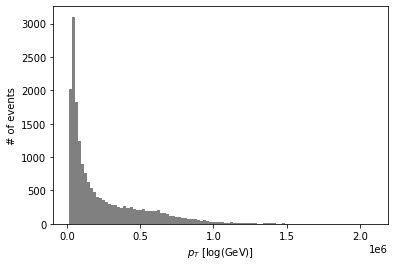

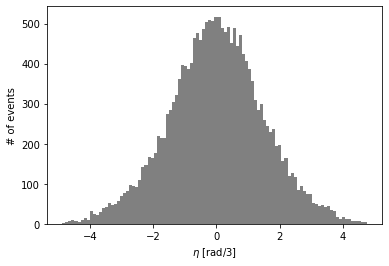

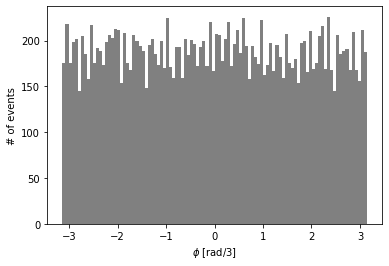

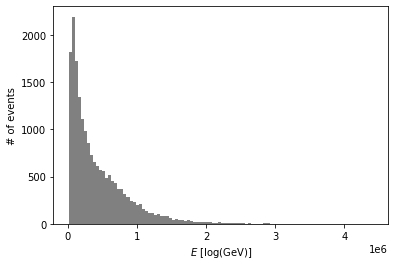

In [65]:
import matplotlib.pyplot as plt

unit_list = ['[log(GeV)]', '[rad/3]', '[rad/3]', '[log(GeV)]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']

# change 'm' to 'E'
branches=["pt","eta","phi","E"]

n_bins = 100

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('# of events')
    #plt.savefig("fourmomentum_"+branches[kk],dpi=300)
    plt.show()

## Setting up the network

### Preparing the data

Adding the two datasets as TensorDatasets to PyTorch (also loading all other classes we'll need later)

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
torch.device = 'cpu'
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

In [75]:
# Set env for running torch training on pc
# device = torch.device('cpu')
# torch.backends.cudnn.benchmark = True

In [76]:
train_x = train
test_x = test
train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

We now set things up to load the data, and we use a batch size that was optimized by previous students...note also that this is fastai v2, migration thanks to Jessica Lastow.

In [68]:
bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

### Preparing the network

Here we have an example network. Details aren't too important, as long as they match what was already trained for us...in this case we have a LeakyReLU, tanh activation function, and a number of layers that goes from 4 to 200 to 20 to 3 (number of features in the hidden layer that we pick for testing compression) and then back all the way to 4. 

In [69]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

#model = AE_3D_200_LeakyReLU().double()
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

We now have to pick a loss function - MSE loss is appropriate for a compression autoencoder since it reflects the [(input-output)/input] physical quantity that we want to minimize. 

In [88]:
from fastai.metrics import mse

loss_func = nn.MSELoss()

#bn_wd = False  # Don't use weight decay for batchnorm layers
#true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls=dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)

#was:= learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

## Alternative 1: Running a pre-trained network

Now we load the pre-trained network. 

In [82]:
learn.load("4D_TLA_leading")

/home/mrd/Documents/atlas_cern/lib/python3.8/site-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


Then we evaluate the MSE on this network - it should be of the order of 0.001 or less if all has gone well...if it has not trained as well (note the pesky 0-mass peak above...) then it's going to be a bit higher.

In [87]:
# torch.device('cpu')
learn.validate()

TypeError: 'NoneType' object is not subscriptable

## Alternative 2: Training a new network

Instead of using a pre-trained network, an alternative is to train a new network and use that instead. 

First, we want to find the best learning rate. The learning rate is a hyper-paramater that sets how much the weights of the network will change each step with respect to the loss gradient.

Then we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of learning rate, so we plot with a log scale.

A good value for the learning rates is then either:
- one tenth of the minimum before the divergence
- when the slope is the steepest

In [74]:
from fastai.callback import schedule
# torch.device('cpu')
# learn.to('cpu')
lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

AttributeError: 'DataLoader' object has no attribute 'device'

Now we want to run the training!

User-chosen variables:
- n_epoch: The number of epochs, i.e how many times the to run through all of the training data once (i.e the 1266046 entries, see cell 2)
- lr: The learning rate. Either choose lr_min, lr_steep from above or set your own.


In [77]:
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(n_epoch=100, lr=lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

NameError: name 'lr_min' is not defined

Then we plot the loss as a function of batches and epochs to check if we reach a plateau.

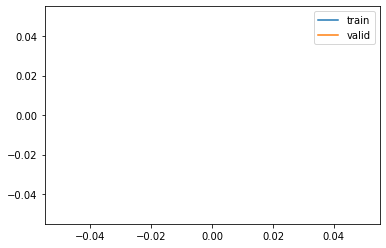

In [60]:
recorder.plot_loss()

Then we evaluate the MSE on this network - it should be of the order of 0.001 or less if all has gone well...if it has not trained as well (note the pesky 0-mass peak above...) then it's going to be a bit higher.

In [61]:
learn.validate()

AttributeError: 'DataLoader' object has no attribute 'device'

Let's plot all of this, with ratios (thanks to code by Erik Wallin)

## Plotting the outputs of the network

Lazy-save of our output files (they'll also be on screen)

In [62]:
import os
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

A function in case we want to un-normalize and get back to physical quantities...

In [63]:
def custom_unnormalize(df):
    df['eta'] = df['eta'] * 5
    df['phi'] = df['phi'] * 3
    df['E'] = 10**df['E']
    #df['m'] = 10**df['m']
    df['pt'] = 10**(df['pt'])
    return df

Make the histograms from the dataset...

ValueError: supplied range of [inf, inf] is not finite

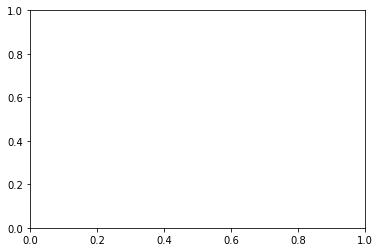

In [64]:
import numpy as np

plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

save = False # Option to save figure

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float)
#data = torch.tensor(test[idxs[0]:idxs[1]].values, dtype=torch.float).double()
pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test.columns)
pred_df = pd.DataFrame(pred, columns=test.columns)

unnormalized_data_df = custom_unnormalize(data_df)
unnormalized_pred_df = custom_unnormalize(pred_df)    
    
alph = 0.8
n_bins = 200
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(test.columns[kk])
    plt.xlabel(test.columns[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,test.columns[kk]+'.png'))
    plt.legend()

In [38]:
def getRatio(bin1,bin2):
    bins = []
    for b1,b2 in zip(bin1,bin2):
        if b1==0 and b2==0:
            bins.append(0.)
        elif b2==0:
            bins.append(None)
        else:
            bins.append((float(b2)-float(b1))/b1)
    return bins   

rat = getRatio(n_hist_data,n_hist_pred)
#print(rat)